# RECONHECIMENTO DE CARACTERES UTILIZANDO MOBILENETV3

Este projeto consiste no desenvolvimento de um sistema de classificação de imagens utilizando aprendizado profundo com TensorFlow e a arquitetura MobileNetV3. Inicialmente, os dados são organizados e carregados a partir do Google Drive, com os arquivos ZIP extraídos e divididos em conjuntos de treino, validação e teste. As imagens são convertidas para o formato RGB e pré-processadas para atender aos requisitos do modelo MobileNet. O modelo é então construído a partir de uma base pré-treinada, com uma nova camada de saída adaptada às classes do problema, e configurado para treinamento. Durante o treinamento, o uso dos recursos computacionais é monitorado para garantir eficiência, e técnicas como checkpoint e early stopping são aplicadas para otimizar o processo. Por fim, o desempenho do modelo é avaliado com uma matriz de confusão, que permite analisar detalhadamente a precisão das classificações em cada categoria.

## Montagem do Google Drive no ambiente Colab

Conexão com o Google Colab ao Google Drive, o que permite acessar arquivos armazenados no Drive como se estivessem no ambiente local. Após a autenticação, o conteúdo do Drive fica disponível no caminho /content/drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Imports

In [ ]:

from google.colab import files
import zipfile
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.metrics import confusion_matrix
import seaborn as sns
import psutil
import subprocess
import hashlib
import zipfile
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LambdaCallback

## Extração dos arquivos ZIP do dataset armazenados no Google Drive

Definição dos caminhos para os dois arquivos ZIP (de treino e teste) que estão no Google Drive e, em seguida, descompactação de ambos no diretório local do Colab (/content/). Isso prepara os dados para serem utilizados no treinamento e na validação de um modelo.

In [ ]:
# Configurando os caminhos
train_zip_path = '/content/drive/My Drive/dataset/train.zip'
test_zip_path = '/content/drive/My Drive/dataset/test.zip'

with zipfile.ZipFile(train_zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/')

with zipfile.ZipFile(test_zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/')

## Configuração da GPU e parâmetros do dataset


Configuração do TensorFlow para utilizar a memória da GPU de forma dinâmica, evitando o uso total da memória logo no início. Em seguida, define os caminhos das pastas que contêm os conjuntos de treino e validação, além de estabelecer o tamanho das imagens e o tamanho do lote que será usado durante o carregamento dos dados.

In [ ]:
#Limitar Memória GPU
gpus = tf.config.experimental.list_physical_devices("GPU")
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

#Paths datasets
train_path = '/content/train'
test_path = '/content/val'
img_height, img_width = 75, 100
batch_size = 32


## Carregamento e divisão dos datasets de imagens



 Carregamento dos datasets de imagens a partir das pastas locais, configurando as imagens para serem carregadas em tons de cinza com tamanho definido. O conjunto de treino é automaticamente dividido em 80% para treino e 20% para validação, garantindo aleatoriedade controlada pela semente. Já o conjunto de teste é carregado separadamente sem embaralhamento. Ao final, são listadas as classes presentes no conjunto de treino para conferência.

In [ ]:
#Carregando datasets e splittando train dataset em 20% pra validation
train_data = tf.keras.utils.image_dataset_from_directory(
    train_path,
    image_size=(img_height, img_width),
    color_mode="grayscale",
    batch_size=batch_size,
    shuffle=True,
    validation_split=0.2,
    subset='training',
    seed=42
)

validation_data = tf.keras.utils.image_dataset_from_directory(
    train_path,
    image_size=(img_height, img_width),
    color_mode="grayscale",
    batch_size=batch_size,
    shuffle=True,
    validation_split=0.2,
    subset='validation',
    seed=42
)

test_data = tf.keras.utils.image_dataset_from_directory(
    test_path,
    image_size=(img_height, img_width),
    color_mode="grayscale",
    batch_size=batch_size,
    shuffle=False
)

class_names = train_data.class_names
print("Classes:", class_names)

Found 24850 files belonging to 35 classes.
Using 19880 files for training.
Found 24850 files belonging to 35 classes.
Using 4970 files for validation.
Found 10650 files belonging to 35 classes.
Classes: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


## Conversão de imagens para RGB e pré-processamento


Conversão das imagens em escala de cinza para o formato RGB, pois o modelo MobileNet requer imagens com três canais de cor. Em seguida, aplica a função de pré-processamento específica do MobileNet para normalizar os pixels, preparando os dados para o treinamento e avaliação do modelo. Essa transformação é feita nos conjuntos de treino, validação e teste.

In [ ]:
# (MobileNet espera RGB)
train_data = train_data.map(lambda x, y: (tf.image.grayscale_to_rgb(x), y))
validation_data = validation_data.map(lambda x, y: (tf.image.grayscale_to_rgb(x), y))
test_data = test_data.map(lambda x, y: (tf.image.grayscale_to_rgb(x), y))

#Pré-processamento
train_data = train_data.map(lambda x, y: (preprocess_input(x), y))
validation_data = validation_data.map(lambda x, y: (preprocess_input(x), y))
test_data = test_data.map(lambda x, y: (preprocess_input(x), y))

## Visualização de imagens do conjunto de treino


Exibe quatro imagens do conjunto de treino com seus respectivos rótulos (classes). Ele cria uma figura com quatro subplots lado a lado e plota as imagens convertidas para o formato visualizável, mostrando também o nome da classe de cada imagem no título de cada subplot.

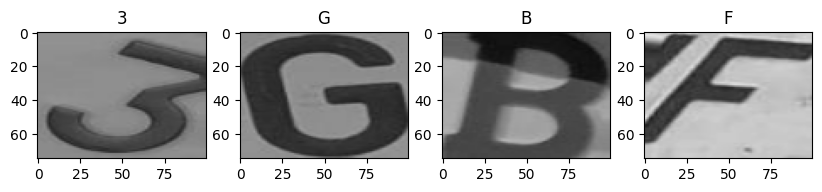

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(10, 3))
for images, labels in train_data.take(1):
    for i in range(4):
        ax[i].imshow(images[i].numpy().astype(np.uint8))
        ax[i].set_title(class_names[labels[i]])
plt.show()

## Construção e compilação do modelo MobileNetV3



Neste trecho, é criado um modelo baseado na arquitetura MobileNetV3Small pré-treinada no ImageNet, sem a camada final de classificação. A base do modelo é congelada para evitar treinamento dos seus pesos inicialmente. Em seguida, adiciona-se uma camada de pooling global e uma camada densa com ativação softmax para classificar as imagens nas categorias definidas. Por fim, o modelo é compilado usando o otimizador Adam, a função de perda para classificação multiclasse e a métrica de acurácia.

In [ ]:
base_model = MobileNetV3Small(
    input_shape=(img_height, img_width, 3),
    weights="imagenet",
    include_top=False
)
base_model.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(len(class_names), activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

/usr/local/lib/python3.11/dist-packages/keras/src/applications/mobilenet_v3.py:452: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


4334752/4334752 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


## Funções para monitoramento de uso de recursos durante o treinamento



Definição de funções para monitorar o uso da CPU, memória RAM e GPU durante o treinamento do modelo. A função gpu_usage obtém o uso de memória da GPU usando o comando nvidia-smi. A função log_resources imprime o uso atual da CPU, RAM e GPU ao final de cada época de treinamento. Por fim, é criado um callback resource_logger que executa essa função automaticamente ao final de cada época para auxiliar no acompanhamento do consumo de recursos do sistema.

In [ ]:
def gpu_usage():
    try:
        print(subprocess.getoutput("nvidia-smi --query-gpu=memory.used,memory.total --format=csv,noheader,nounits"))
    except:
        print("GPU info unavailable")

def log_resources(epoch, logs):
    cpu = psutil.cpu_percent()
    mem = psutil.virtual_memory().percent
    print(f"Epoch {epoch+1}: CPU={cpu:.2f}% | RAM={mem:.2f}%")
    gpu_usage()

resource_logger = LambdaCallback(on_epoch_end=log_resources)

## Treinamento do modelo com callbacks e avaliação final

O código realiza o treinamento do modelo por até 30 épocas, usando os dados de treino e validando com os dados de validação. Durante o processo, ele salva automaticamente o melhor modelo baseado na acurácia de validação, para evitar perdas de progresso. Também para o treinamento antecipadamente se a acurácia de validação não melhorar após cinco épocas consecutivas. Além disso, monitora o uso dos recursos do sistema em cada época. Ao final, o modelo é avaliado com os dados de teste, mostrando a perda e a acurácia obtidas.

In [ ]:
history = model.fit(
    train_data,
    epochs=30,
    validation_data=validation_data,
    callbacks=[
        ModelCheckpoint("./models/checkpoints_new/{epoch:02d}.h5", save_best_only=True),
        EarlyStopping(monitor='val_accuracy', patience=5), resource_logger
    ]
)

print("Loss & Acuracia:", model.evaluate(test_data))

Epoch 1/30
622/622 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5589 - loss: 2.0433

Epoch 1: CPU=33.60% | RAM=19.10%
388, 15360
622/622 ━━━━━━━━━━━━━━━━━━━━ 34s 39ms/step - accuracy: 0.5593 - loss: 2.0421 - val_accuracy: 0.9097 - val_loss: 0.6162
Epoch 2/30
619/622 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9280 - loss: 0.5089

Epoch 2: CPU=57.30% | RAM=19.30%
390, 15360
622/622 ━━━━━━━━━━━━━━━━━━━━ 24s 20ms/step - accuracy: 0.9280 - loss: 0.5085 - val_accuracy: 0.9491 - val_loss: 0.3467
Epoch 3/30
621/622 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9570 - loss: 0.2969

Epoch 3: CPU=94.70% | RAM=19.40%
390, 15360
622/622 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - accuracy: 0.9570 - loss: 0.2968 - val_accuracy: 0.9642 - val_loss: 0.2386
Epoch 4/30
620/622 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9721 - loss: 0.2037

Epoch 4: CPU=64.90% | RAM=19.30%
390, 15360
622/622 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - accuracy: 0.9721 - loss: 0.2036 - val_accuracy: 0.9732 - val_loss: 0.1812
Epoch 5/30
618/622 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9794 - loss: 0.1508

Epoch 5: CPU=98.90% | RAM=19.40%
390, 15360
622/622 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - accuracy: 0.9795 - loss: 0.1508 - val_accuracy: 0.9807 - val_loss: 0.1420
Epoch 6/30
620/622 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9853 - loss: 0.1160

Epoch 6: CPU=94.50% | RAM=19.20%
390, 15360
622/622 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - accuracy: 0.9854 - loss: 0.1159 - val_accuracy: 0.9861 - val_loss: 0.1131
Epoch 7/30
620/622 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9886 - loss: 0.0921

Epoch 7: CPU=98.80% | RAM=19.40%
390, 15360
622/622 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - accuracy: 0.9886 - loss: 0.0921 - val_accuracy: 0.9883 - val_loss: 0.0951
Epoch 8/30
619/622 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9918 - loss: 0.0747

Epoch 8: CPU=95.10% | RAM=19.30%
390, 15360
622/622 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - accuracy: 0.9918 - loss: 0.0747 - val_accuracy: 0.9915 - val_loss: 0.0789
Epoch 9/30
620/622 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9950 - loss: 0.0605

Epoch 9: CPU=63.90% | RAM=19.40%
390, 15360
622/622 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - accuracy: 0.9950 - loss: 0.0604 - val_accuracy: 0.9915 - val_loss: 0.0694
Epoch 10/30
620/622 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9963 - loss: 0.0505

Epoch 10: CPU=66.60% | RAM=19.20%
390, 15360
622/622 ━━━━━━━━━━━━━━━━━━━━ 19s 20ms/step - accuracy: 0.9963 - loss: 0.0505 - val_accuracy: 0.9938 - val_loss: 0.0594
Epoch 11/30
621/622 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9970 - loss: 0.0425

Epoch 11: CPU=98.90% | RAM=19.40%
390, 15360
622/622 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - accuracy: 0.9970 - loss: 0.0425 - val_accuracy: 0.9944 - val_loss: 0.0519
Epoch 12/30
619/622 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9978 - loss: 0.0360

Epoch 12: CPU=62.50% | RAM=19.40%
390, 15360
622/622 ━━━━━━━━━━━━━━━━━━━━ 22s 22ms/step - accuracy: 0.9978 - loss: 0.0360 - val_accuracy: 0.9948 - val_loss: 0.0458
Epoch 13/30
619/622 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9984 - loss: 0.0308

Epoch 13: CPU=66.30% | RAM=19.30%
390, 15360
622/622 ━━━━━━━━━━━━━━━━━━━━ 19s 20ms/step - accuracy: 0.9984 - loss: 0.0308 - val_accuracy: 0.9956 - val_loss: 0.0410
Epoch 14/30
620/622 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9987 - loss: 0.0262

Epoch 14: CPU=98.80% | RAM=19.20%
390, 15360
622/622 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - accuracy: 0.9987 - loss: 0.0262 - val_accuracy: 0.9952 - val_loss: 0.0370
Epoch 15/30
618/622 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9991 - loss: 0.0226

Epoch 15: CPU=95.90% | RAM=19.30%
390, 15360
622/622 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - accuracy: 0.9991 - loss: 0.0226 - val_accuracy: 0.9960 - val_loss: 0.0343
Epoch 16/30
620/622 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9994 - loss: 0.0196

Epoch 16: CPU=65.90% | RAM=19.20%
390, 15360
622/622 ━━━━━━━━━━━━━━━━━━━━ 21s 22ms/step - accuracy: 0.9994 - loss: 0.0196 - val_accuracy: 0.9968 - val_loss: 0.0299
Epoch 17/30
620/622 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9994 - loss: 0.0170

Epoch 17: CPU=98.90% | RAM=19.40%
390, 15360
622/622 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - accuracy: 0.9994 - loss: 0.0170 - val_accuracy: 0.9968 - val_loss: 0.0275
Epoch 18/30
621/622 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9998 - loss: 0.0150

Epoch 18: CPU=86.80% | RAM=19.20%
390, 15360
622/622 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - accuracy: 0.9998 - loss: 0.0150 - val_accuracy: 0.9966 - val_loss: 0.0258
Epoch 19/30
619/622 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9999 - loss: 0.0130

Epoch 19: CPU=63.90% | RAM=19.20%
390, 15360
622/622 ━━━━━━━━━━━━━━━━━━━━ 20s 21ms/step - accuracy: 0.9999 - loss: 0.0130 - val_accuracy: 0.9968 - val_loss: 0.0232
Epoch 20/30
620/622 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9998 - loss: 0.0114

Epoch 20: CPU=95.20% | RAM=19.30%
390, 15360
622/622 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - accuracy: 0.9998 - loss: 0.0114 - val_accuracy: 0.9968 - val_loss: 0.0216
Epoch 21/30
618/622 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 0.0100

Epoch 21: CPU=98.80% | RAM=19.30%
390, 15360
622/622 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - accuracy: 1.0000 - loss: 0.0100 - val_accuracy: 0.9970 - val_loss: 0.0199
Epoch 22/30
621/622 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 0.0089

Epoch 22: CPU=66.50% | RAM=19.30%
390, 15360
622/622 ━━━━━━━━━━━━━━━━━━━━ 20s 20ms/step - accuracy: 1.0000 - loss: 0.0089 - val_accuracy: 0.9974 - val_loss: 0.0182
Epoch 23/30
621/622 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 0.0078

Epoch 23: CPU=85.80% | RAM=19.30%
390, 15360
622/622 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - accuracy: 1.0000 - loss: 0.0078 - val_accuracy: 0.9974 - val_loss: 0.0172
Epoch 24/30
619/622 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 0.0069

Epoch 24: CPU=87.00% | RAM=19.40%
390, 15360
622/622 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - accuracy: 1.0000 - loss: 0.0069 - val_accuracy: 0.9978 - val_loss: 0.0157
Epoch 25/30
620/622 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 0.0061

Epoch 25: CPU=99.00% | RAM=19.40%
390, 15360
622/622 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - accuracy: 1.0000 - loss: 0.0061 - val_accuracy: 0.9978 - val_loss: 0.0151
Epoch 26/30
619/622 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 0.0055

Epoch 26: CPU=99.50% | RAM=19.30%
390, 15360
622/622 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 1.0000 - loss: 0.0055 - val_accuracy: 0.9980 - val_loss: 0.0145
Epoch 27/30
618/622 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 0.0049

Epoch 27: CPU=59.40% | RAM=19.40%
390, 15360
622/622 ━━━━━━━━━━━━━━━━━━━━ 22s 21ms/step - accuracy: 1.0000 - loss: 0.0049 - val_accuracy: 0.9978 - val_loss: 0.0129
Epoch 28/30
621/622 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 0.0043

Epoch 28: CPU=67.90% | RAM=19.40%
390, 15360
622/622 ━━━━━━━━━━━━━━━━━━━━ 20s 20ms/step - accuracy: 1.0000 - loss: 0.0043 - val_accuracy: 0.9978 - val_loss: 0.0128
Epoch 29/30
620/622 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 0.0039

Epoch 29: CPU=88.10% | RAM=19.40%
390, 15360
622/622 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - accuracy: 1.0000 - loss: 0.0039 - val_accuracy: 0.9982 - val_loss: 0.0116
Epoch 30/30
620/622 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 0.0035

Epoch 30: CPU=66.00% | RAM=19.40%
390, 15360
622/622 ━━━━━━━━━━━━━━━━━━━━ 19s 20ms/step - accuracy: 1.0000 - loss: 0.0035 - val_accuracy: 0.9982 - val_loss: 0.0111
333/333 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.9956 - loss: 0.0156
Loss & Acuracia: [0.01181840430945158, 0.9968075156211853]


## Predições, matriz de confusão e visualização dos resultados


Realização das predições do modelo usando o conjunto de teste, coletando as classes verdadeiras e previstas. Com esses dados, calcula-se a matriz de confusão, que mostra a quantidade de classificações corretas e incorretas para cada classe. Em seguida, essa matriz é exibida em um gráfico de calor (heatmap) para facilitar a análise visual do desempenho do modelo em cada categoria.

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━

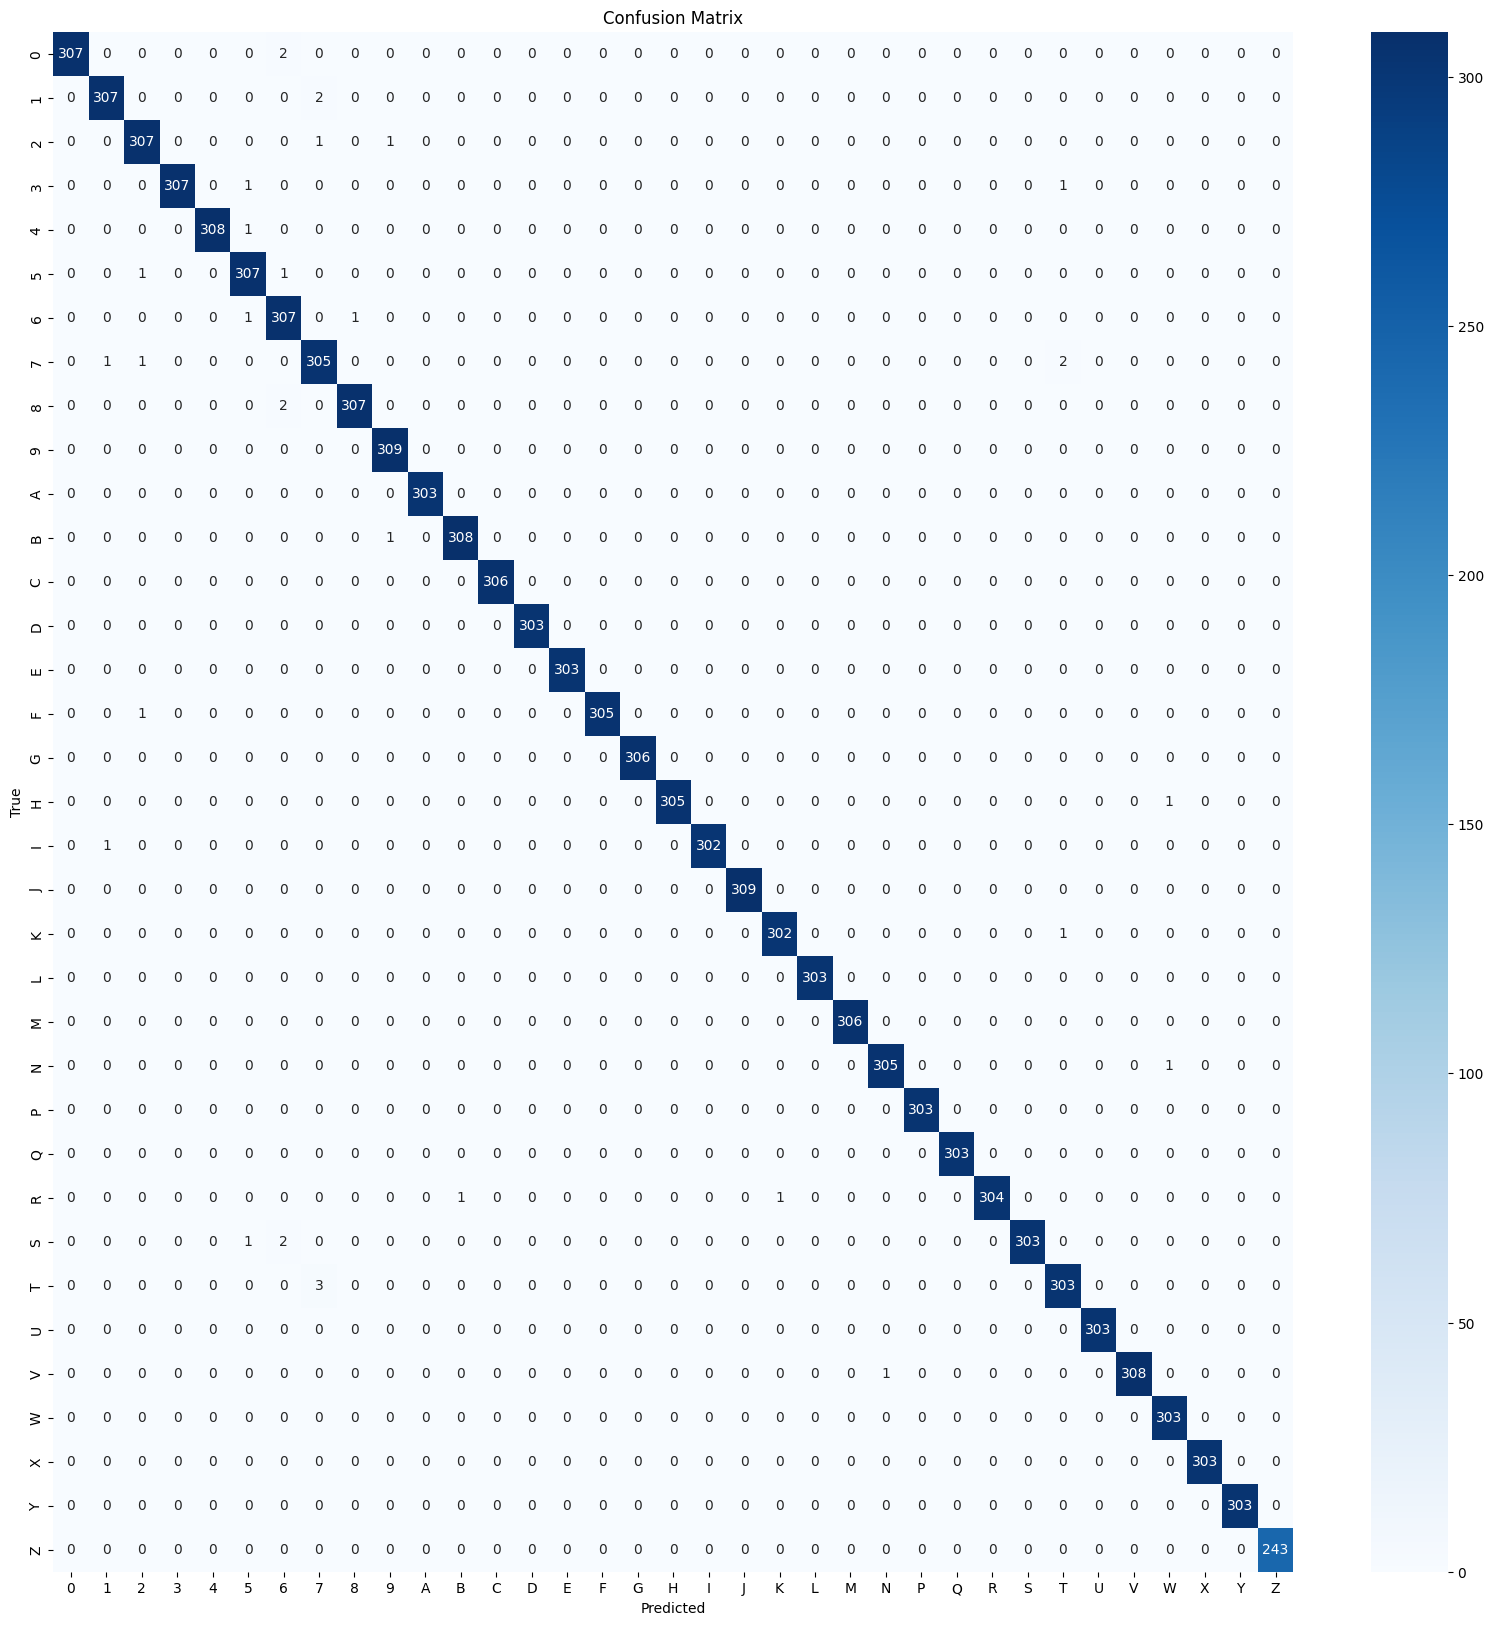

In [ ]:
#Predições, Matriz de Confusão e labels verdadeiras
y_true = []
y_pred = []
for images, labels in test_data:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

conf_mat = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(20, 20))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()